<a href="https://colab.research.google.com/github/KevinSassani/DINOv2-Project/blob/main/DinoV2_classification_food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import datasets
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from glob import glob
from PIL import Image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from google.colab import drive
drive.mount('/content/drive')

checkpoints_dir = "/content/drive/MyDrive/Project/Checkpoints_Classifier/"
assert os.path.exists(checkpoints_dir),\
    "The path you provided does not exitst!"\
    " Consider creating the folder manually."

cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
def save_checkpoint(model,optimizer,loss,acc,epoch,checkpoints_dir, is_best=False):

    if is_best:
        path = checkpoints_dir+str(model.__class__.__name__)+'_best_checkpoint_'+str(epoch)+'.pth'
    else:
        path = checkpoints_dir+str(model.__class__.__name__)+'_checkpoint_'+str(epoch)+'.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': acc,
    }, path)

def load_checkpoint(path, model): # Pass 'model' as an argument
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    acc = checkpoint['accuracy']
    return model

#### Load Model

In [8]:
dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 196MB/s]
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_linear4_head.pth" to /root/.cache/torch/hub/che

#### Download Dataset

100%|██████████| 5.00G/5.00G [04:44<00:00, 17.5MB/s]


Extracting food101/food-101.tar.gz to food101


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

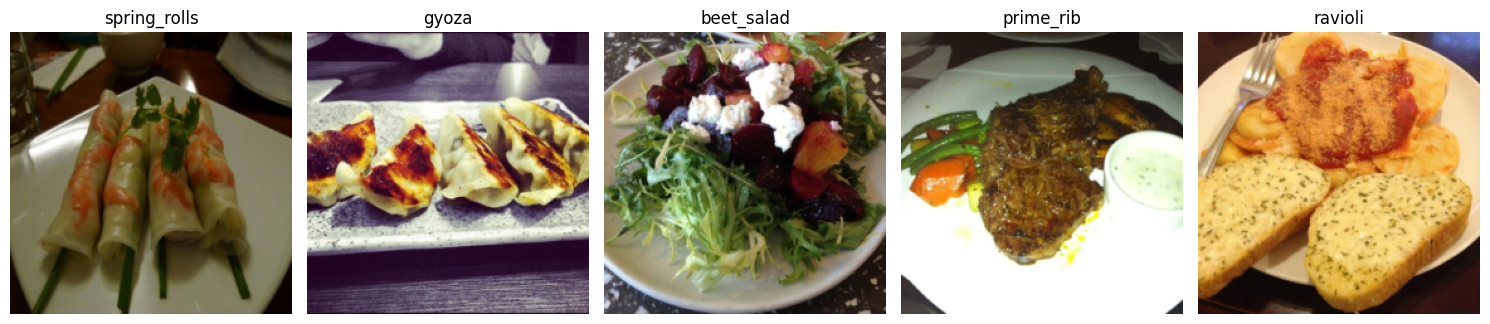

In [9]:
batch_size = 100
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors and normalize to [0, 1]
])

train_data = torchvision.datasets.Food101(root='food101', split='train', download=True, transform=transform)
test_data = torchvision.datasets.Food101(root='food101', split='test', download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
# Randomly select 5 samples
random_indices = random.sample(range(len(train_data)), 5)
samples = [train_data[idx] for idx in random_indices]

# Plot the samples
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, label) in enumerate(samples):
    axs[i].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
    axs[i].axis('off')  # Turn off axes
    axs[i].set_title(train_data.classes[label])  # Set the title to the class name

plt.tight_layout()
plt.show()

#### Replace Existing Head With New Head

In [ ]:
# Inspect the current classification head
existing_head = dinov2_vits14_lc.linear_head

# Get the shape of the existing head
input_features = existing_head.in_features
output_features = existing_head.out_features

# Initialize a new classification head with random weights
new_head = nn.Linear(input_features, output_features)

print(f"New head initialized with shape: {input_features} -> {output_features}")
import copy

# Deep copy the model
dinov2_vits14_lc_original = copy.deepcopy(dinov2_vits14_lc)
dinov2_vits14_lc.linear_head = new_head

# freeze all weights in the dinov2_vits14_lc_copy except the new head
for param in dinov2_vits14_lc.parameters():
    param.requires_grad = False

# unfreeze the new head
for param in dinov2_vits14_lc.linear_head.parameters():
    param.requires_grad = True

# save_checkpoint('/checkpoints',dinov2_vits14_lc,0)

New head initialized with shape: 1920 -> 1000


TypeError: save_checkpoint() missing 2 required positional arguments: 'acc' and 'epoch'

#### Load Model

In [43]:
#checkpoint = torch.load(checkpoints_dir+'LinearClassifierWrapper_checkpoint19_epochs.pth')
#model = checkpoint['model_state_dict']
#print(model)

model = dinov2_vits14_lc
model_path = checkpoints_dir+'_LinearClassifierWrapper_checkpoint_25.pth'
model = load_checkpoint(model_path, model)
model.eval()
dinov2_vits14_lc = model

for param in dinov2_vits14_lc.parameters():
    param.requires_grad = False

# unfreeze the new head
for param in dinov2_vits14_lc.linear_head.parameters():
    param.requires_grad = True

<ipython-input-29-58b0647a7e61>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [31]:
def test_accuracy(model,test_loader):
    model.eval()
    correct = 0
    total = 0
    batches = len(test_loader)
    with torch.no_grad():
        batch = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch += 1
            if batch > 0.2*batches:# Only validate on 20 % of the data for more efficient testing
              break

    accuracy = correct / total
    return accuracy

In [ ]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vits14_lc.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dinov2_vits14_lc.linear_head.parameters(), lr=1e-3,weight_decay=5e-4)
end_epoch = 40
start_epoch = 25
print(checkpoints_dir)
test_accuracy_list = []

for epoch in range(start_epoch+1, end_epoch):
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{end_epoch}")
    for batch_idx, (images, labels) in progress_bar:
        optimizer.zero_grad()
        # input = processor(images=batch[0], return_tensors="pt")
        input = processor(images=images, return_tensors="pt", padding=True).to(device)
        # input = processor(images=batch[0], return_tensors="pt").to(device)
        labels = labels.to(device)
        output = dinov2_vits14_lc(input["pixel_values"])
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # Update progress bar with loss
        progress_bar.set_postfix(loss=loss.item(),accuracy=f"{100*correct/total:.2f}%")


    #print(f"Epoch {i + 1}, Loss: {loss_val.item()}")
    if epoch % 1 == 0:    # Save evert iteration
        test_acc = test_accuracy(dinov2_vits14_lc,test_loader)
        test_accuracy_list.append(test_acc)
        #if test_acc == max(test_accuracy_list):
        #    save_checkpoint(dinov2_vits14_lc,optimizer,loss_function,test_acc,i,checkpoints_dir,is_best=True)
        #else:
        save_checkpoint(dinov2_vits14_lc,optimizer,loss_function,test_acc,epoch,checkpoints_dir)


/content/drive/MyDrive/Project/Checkpoints_Classifier/


Epoch 26/40:   0%|          | 0/758 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `BitImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Epoch 26/40:  77%|███████▋  | 581/758 [15:18<04:30,  1.53s/it, accuracy=15.90%, loss=3.75]

In [30]:

save_checkpoint(dinov2_vits14_lc,optimizer,loss_function,test_acc,i,checkpoints_dir)

In [ ]:
with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            for i in range(labels.shape[0]):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc_net = 100.0 * n_correct / n_samples

        print(f'Accuracy of the network: {acc_net} %')

        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {labels_map[i]}: {round(acc,2)} %')